In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./RNN_scripts")
import torch
import matplotlib
import matplotlib.pyplot as plt
from RNN_scripts import dms, ranktwo, clustering
from RNN_scripts.modules import LowRankRNN, train
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
matplotlib.rcParams['figure.figsize'] = (6, 5)
matplotlib.rcParams['font.size'] = 40
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.titlesize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 40
matplotlib.rcParams['ytick.labelsize'] = 40
#matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Load trained model

In [5]:
hidden_size = 500
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'./RNN_scripts/dms_rank2_{hidden_size}.pt', map_location='cpu'))
net.svd_reparametrization()

In [6]:
loss_orig, acc_orig = dms.test_dms(net, x_val, y_val, mask_val)
print(acc_orig)
print(loss_orig)

1.0
0.007406227756291628


# Visualising two network populations

In [7]:
n_pops = 2
z, _ = clustering.gmm_fit(net, n_pops, algo='bayes', random_state=2020)  # z will contain labels for the 2 populations

pop 0: slope=-0.01, intercept=-0.04
pop 1: slope=-0.03, intercept=0.06
pop 0: slope=-0.01, intercept=0.02
pop 1: slope=-0.02, intercept=-0.20


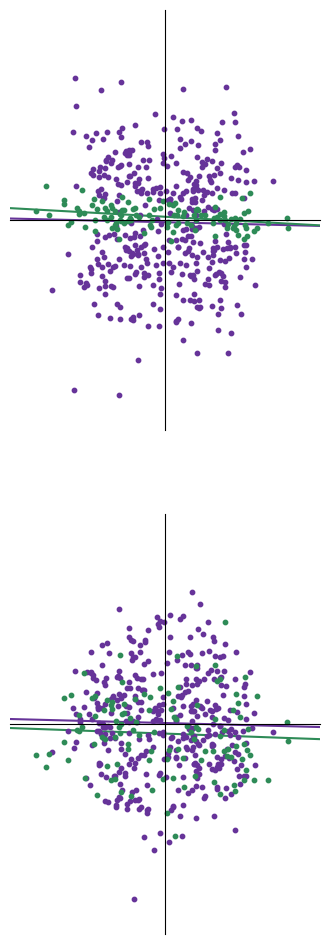

In [8]:
# Visualizing those 2 populations
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy() 
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()

fig, ax = plt.subplots(2, 1, figsize=(4, 12))
colors = ['rebeccapurple', 'seagreen']
fs = 12
clustering.pop_scatter_linreg(n, wi1, z, n_pops, colors=colors, ax=ax[0])
clustering.pop_scatter_linreg(n, wi2, z, n_pops, colors=colors, ax=ax[1])

# Create new network by fitting Gaussian mixture to the connectivity space

In [ ]:
net3 = clustering.to_support_net(net, z, scaling=True)

Check that the resampled networks still give the same validation losses

In [ ]:
accs2 = []
for _ in range(10):
    net3.resample_basis()
    loss, acc = dms.test_dms(net3, x_val, y_val, mask_val)
    accs2.append(acc)

Train net network for a few epochs

In [ ]:
train(net3, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)

# Plot phase portraits of the original system for various parameters

In [9]:
stim1_begin, stim1_end, stim2_begin, stim2_end, decision = 25, 50, 200, 225, 275
epochs = [0, stim1_begin, stim1_end, stim2_begin, stim2_end, decision]
input = torch.zeros(4, decision, 2)
input[0, stim1_begin:stim1_end, 0] = 1
input[0, stim2_begin:stim2_end, 0] = 1
input[1, stim1_begin:stim1_end, 0] = .5
input[1, stim2_begin:stim2_end, 0] = .5
input[2, stim1_begin:stim1_end, 0] = .25
input[2, stim2_begin:stim2_end, 0] = .25
input[3, stim1_begin:stim1_end, 0] = .1
input[3, stim2_begin:stim2_end, 0] = .1

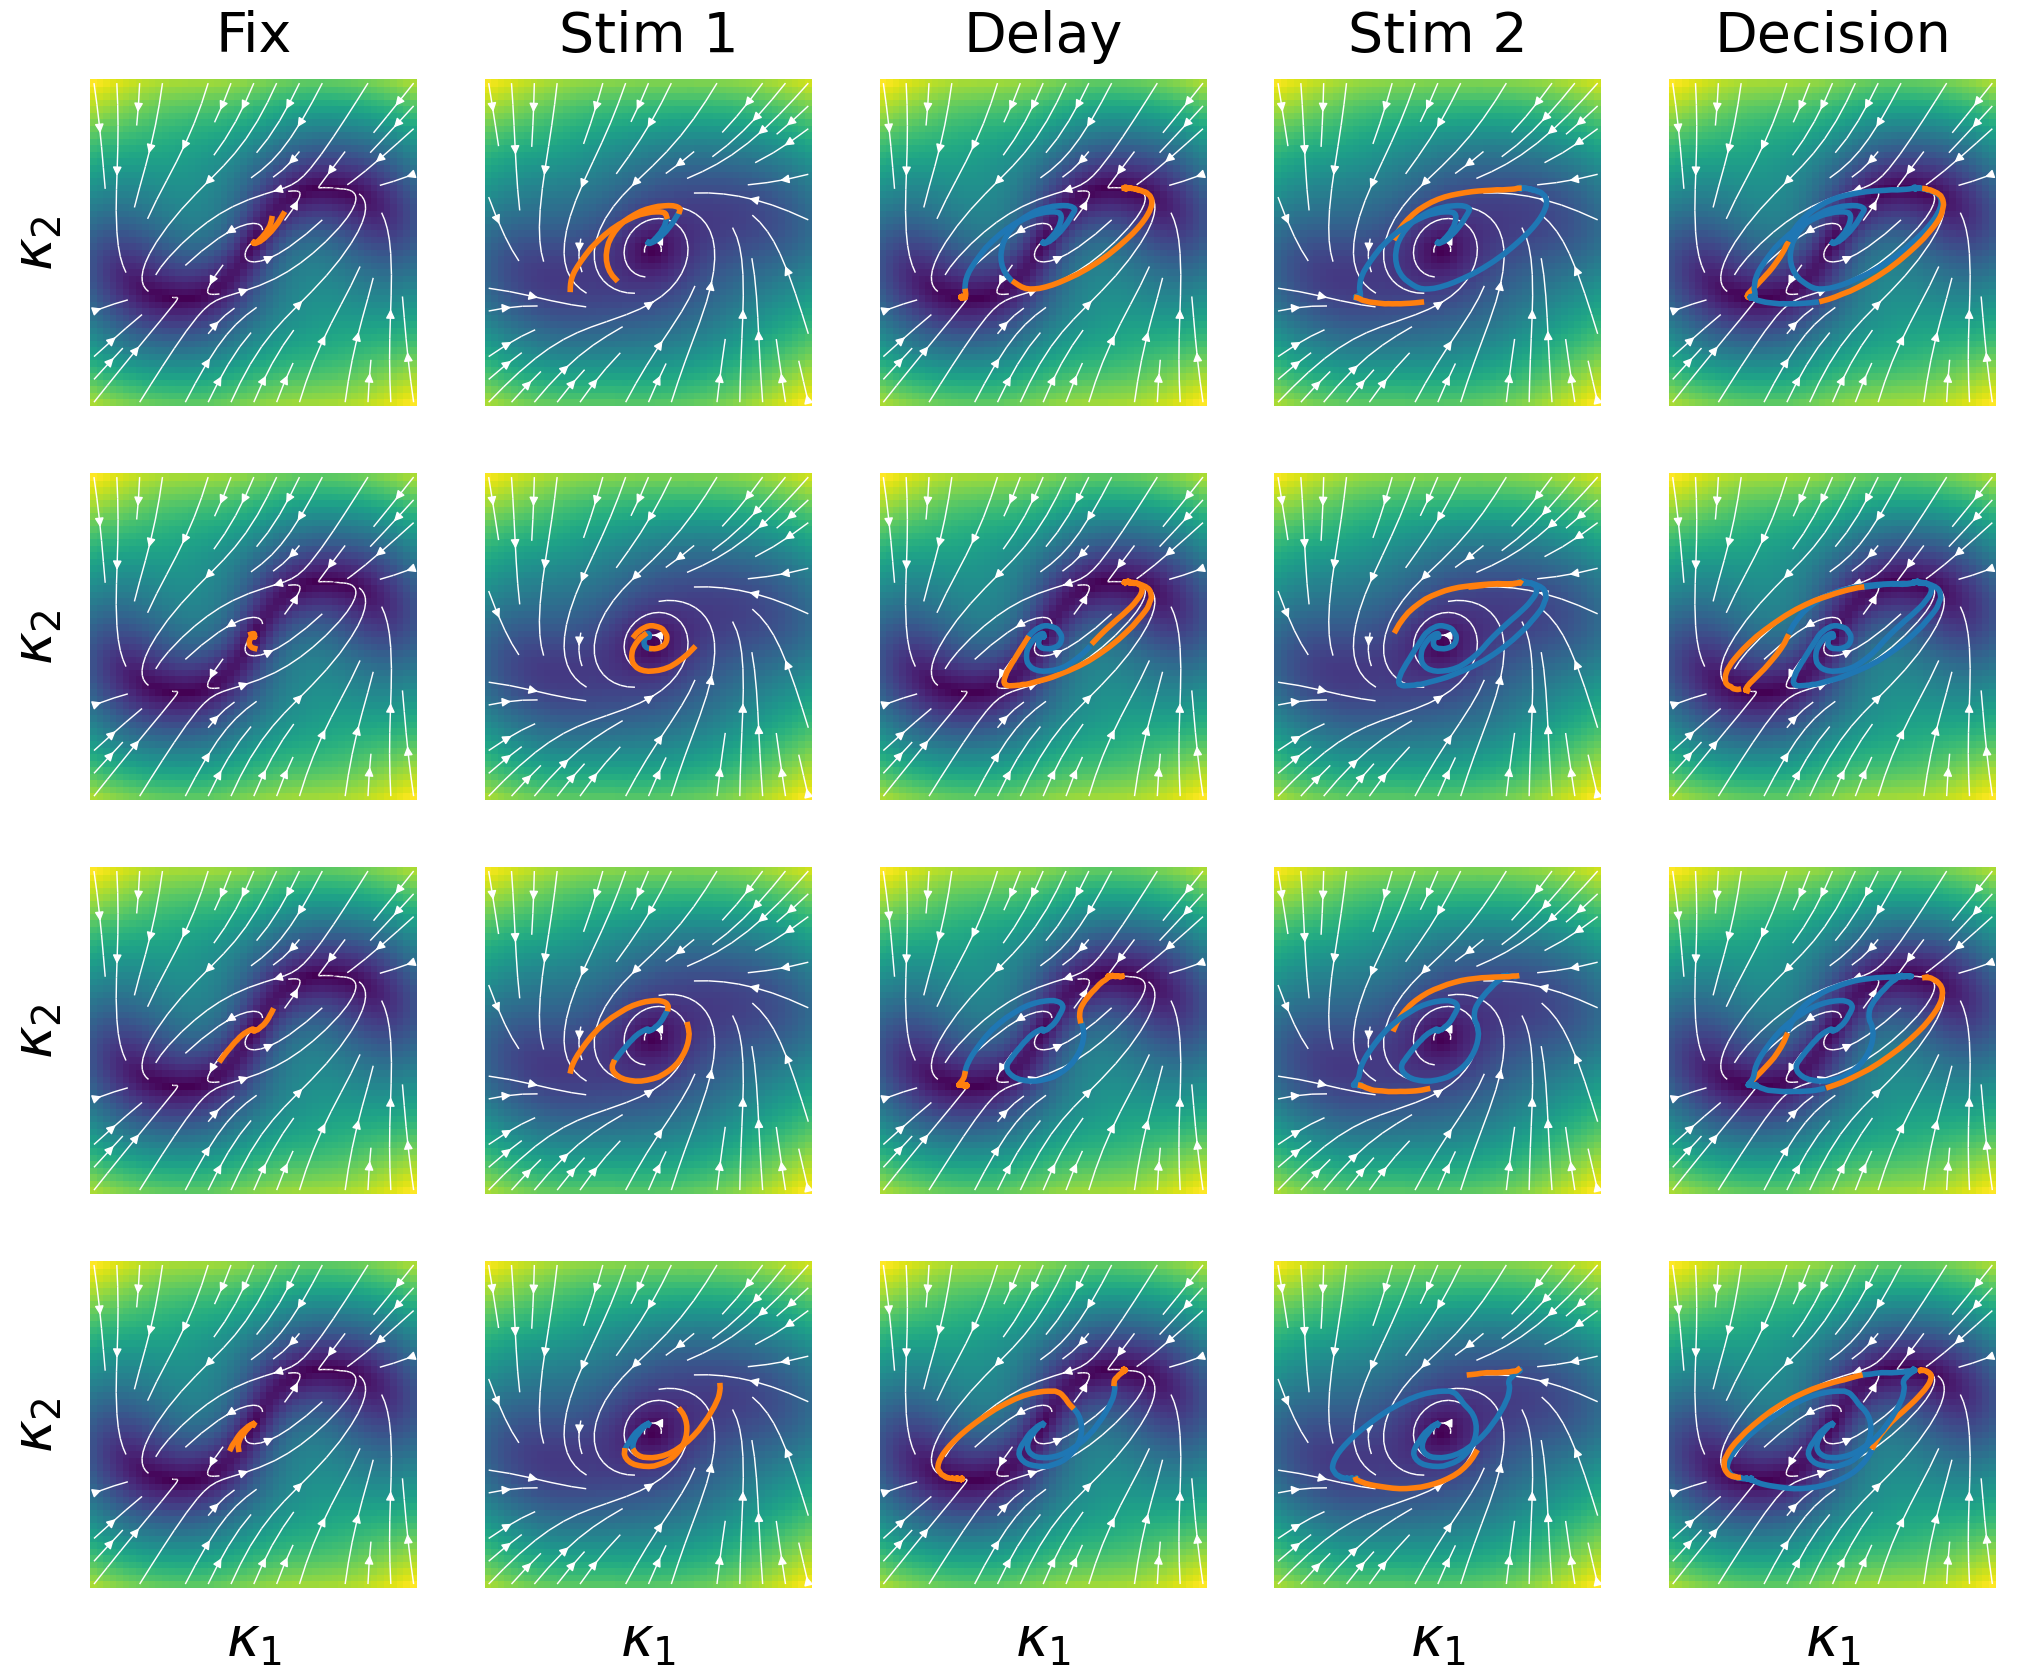

In [42]:
n_traj=2

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i in range(4):
    
    traj = []
    for k in range(n_traj):
        net.h0.data = torch.rand(size=net.h0.data.shape)*0
        _, t = net(input[k].unsqueeze(0))
        traj.append(t.squeeze().detach().numpy())
        
    for j, e in enumerate(epochs[:-1]):
        dms.plot_field(net, input[0, e], ax[i][j], sizes=1.3)
        dms.plot_trajectories(net, traj, ax[i][j], n_traj=len(traj), interval=[e, epochs[j+1]])

ax[0][0].set_title('Fix')
ax[0][1].set_title('Stim 1')
ax[0][2].set_title('Delay')
ax[0][3].set_title('Stim 2')
ax[0][4].set_title('Decision')

for i in range(4):
    ax[i][0].set_ylabel('$\kappa_2$')
for i in range(5):
    ax[3][i].set_xlabel('$\kappa_1$')
    
fig.subplots_adjust(hspace=.1, wspace=.1)
# plt.savefig('figures/si_dms_epochs.pdf')

# Plot phase portraits of the resampled system for various parameters

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i in range(4):
    dms.plot_trial_epochs(net3, 
                          input[i].unsqueeze(0), 
                          epochs, 
                          rect=(-5, 5, -4, 4), 
                          n_traj=20, 
                          sizes=1.3, 
                          axes=ax[i])
    
ax[0][0].set_title('Fix')
ax[0][1].set_title('Stim 1')
ax[0][2].set_title('Delay')
ax[0][3].set_title('Stim 2')
ax[0][4].set_title('Decision')

for i in range(4):
    ax[i][0].set_ylabel('$\kappa_2$')
for i in range(5):
    ax[3][i].set_xlabel('$\kappa_1$')
    
fig.subplots_adjust(hspace=.1, wspace=.1)